### Описание проекта

Нужно разобраться, как ведут себя пользователи мобильного приложения. 
Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого необходимо исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.


<div>
    <h2> 1. Подготовка данных <a class="tocSkip"> </h2>

In [1]:
#импорт необходимых библиотек и инструментов
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math as mth
import plotly.express as px 
import plotly.graph_objects as go

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')  
    
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')


In [3]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
#корректировка названий столбцов
logs.columns = map(str.lower, logs.columns)
logs = logs.rename(columns={'eventname':'event', 'deviceidhash':'user_id', 'eventtimestamp':'event_time', 'expid':'group'})
logs

,event,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
#проверка наличия пропусков
logs.isna().sum()

event         0
user_id       0
event_time    0
group         0
dtype: int64

In [6]:
#проверка наличия дубликатов
logs.duplicated().sum()

413

In [7]:
#удаление дубликатов
logs = logs.drop_duplicates().reset_index(drop=True) 

In [8]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event       243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


In [9]:
# замена типа данных `datetime`: 

logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')

# добавление поля с датой:

logs['date'] = pd.to_datetime(logs['event_time'].dt.date)
logs

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [10]:
duplicate_users = logs.groupby('user_id')['group'].nunique().loc[lambda x: x > 1]

if len(duplicate_users) == 0:
    result = 'Нет уникальных пользователей, попавших в разные группы'
else:
    result = 'Обнаружены уникальные пользователи, попавшие в разные группы'
print(result)


Нет уникальных пользователей, попавших в разные группы


<div>
    <h2> 2. Изучение и проверка данных <a class="tocSkip"> </h2>

Ответим на следующие вопросы:

    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?


In [11]:
print('Всего событий в логе:', logs.shape[0])
print('Всего пользователей в логе:', logs['user_id'].nunique())
print('В среднем событий приходится на пользователя:', round(logs.shape[0]/logs['user_id'].nunique()))

Всего событий в логе: 243713
Всего пользователей в логе: 7551
В среднем событий приходится на пользователя: 32


In [12]:
#найдем максимальную и минимальную дату
print('Максимальная дата:', logs['date'].max())
print('Минимальная дата:', logs['date'].min())

Максимальная дата: 2019-08-07 00:00:00
Минимальная дата: 2019-07-25 00:00:00


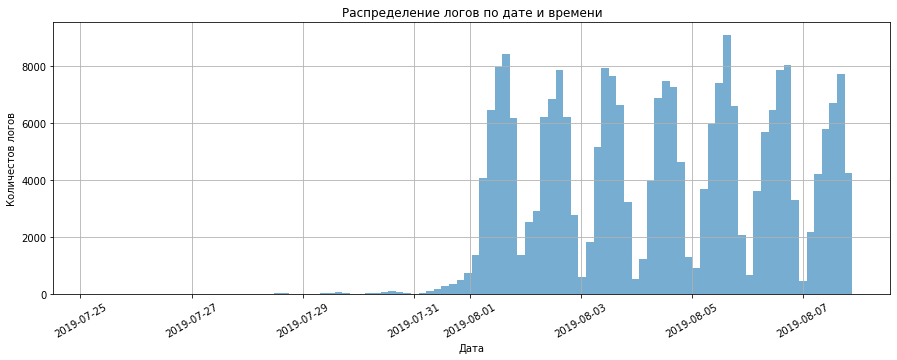

In [13]:
#Построим гистограмму по дате и времени
plt.title('Распределение логов по дате и времени')
logs['event_time'].hist(bins=100,  figsize=(15, 5), alpha=0.6)
plt.ylabel("Количестов логов")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.show()

На гистограмме видим, что за июль сведения не полные. Лучше брать отрезок времения с 2019-08-01 по 2019-08-07

In [14]:
# Проверим, сколько логов и пользователей потеряли, отбросив данные за июль
data = logs[logs['event_time'] >= '2019-08-01']
data
print('Утеряно событий:', logs.shape[0] - data.shape[0], 
      '({:.1%})'.format((logs.shape[0] - data.shape[0])/data.shape[0]))

print('Утеряно пользователей:', logs['user_id'].nunique() - data['user_id'].nunique(), 
      '({:.1%})'.format((logs['user_id'].nunique() - data['user_id'].nunique())/logs['user_id'].nunique()))


Утеряно событий: 2826 (1.2%)
Утеряно пользователей: 17 (0.2%)


In [15]:
# Проверим, есть ли пользователи из всех трёх экспериментальных групп и их количество
data.groupby('group').agg({'user_id': 'nunique', 'group': 'count'})

,user_id,group
group,,
246,2484,79302
247,2513,77022
248,2537,84563


количество уникальных пользователей и количество событий в группах +- одинаковые. группа 248 самая большая по 2м показателям

<div>
    <h2> 3. Изучение воронки событий <a class="tocSkip"> </h2>

In [16]:
# Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте
events = (data.groupby('event')
          .agg({'user_id': 'count'})
          .rename(columns={'user_id' : 'total_events'})
          .sort_values(by='total_events', ascending=False))
events


,total_events
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [17]:
#Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 
users = (data.groupby('event')
         .agg({'user_id': 'nunique'})
         .rename(columns={'user_id' : 'total_users'})
         .sort_values(by='total_users', ascending=False))

In [18]:
#Посчитаем долю пользователей, которые хоть раз совершали событие
users['persent'] = round(users['total_users'] / data['user_id'].nunique() * 100, 2)
users

,total_users,persent
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Все события выстраиваются в последовательную цепочку, кроме события Tutorial. Его можно исключить из воронки событий, т.к. для того чтобы купить что-то не обязательно смотреть урок. 
Таким образом получается последовательность:

    - Главный экран
    - Каталог
    - Карточка товара
    - Оплата товара

In [19]:
# Создание сводной таблицы
users_pivot = data.pivot_table(index='user_id', columns='event', values='event_time', aggfunc='min')

# Список событий в правильной последовательности
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Вычисление метрик в процентах от предыдущего шага с использованием цикла

for i in range(1, len(events)):
    event_count = users_pivot[events[i]].count()
    previous_event_count = users_pivot[events[i-1]].count()
    conversion_rate = event_count / previous_event_count
    print(f'{events[i]} в % от предыдущего шага: {conversion_rate:.2%}')

OffersScreenAppear в % от предыдущего шага: 61.91%
CartScreenAppear в % от предыдущего шага: 81.30%
PaymentScreenSuccessful в % от предыдущего шага: 94.78%


Наибольшее количество пользователей теряется после первого шага, а именно 38,1%, а доля пользователей доходящих от 1го события до оплаты составила 47,71%

<div>
    <h2> 4. Изучение результатов эксперимента <a class="tocSkip"> </h2>

In [20]:
#Определим количество уникальных пользователей в каждой группе
data.groupby('group').agg(count=('user_id', 'nunique'))

,count
group,
246,2484
247,2513
248,2537


In [21]:
#создадим рейтинг событий и разобьем их по группам
most_popular_event = (data.pivot_table(index='event', 
                                      columns='group', 
                                      values='user_id', 
                                      aggfunc='nunique', 
                                      margins=True).reset_index()
                      .sort_values('All', ascending=False)
                      .reset_index(drop=True))
                      
most_popular_event = most_popular_event.query('event != "Tutorial"').reindex().reset_index(drop=True)
most_popular_event

group,event,246,247,248,All
0,All,2484,2513,2537,7534
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
3,CartScreenAppear,1266,1238,1230,3734
4,PaymentScreenSuccessful,1200,1158,1181,3539


Во всех группах количество событий практически одинаково. различия между ними незначительны

<div class="alert alert" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247: </b>


Я сделала 2 функции, с функцией test_1 намудрила, но хотелось бы узнать мнение ревьювера на счет ее жизнеспособности :)

<div class="alert alert" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b> Для того, чтобы сопоставить доли по каждому событию выведем основную и альтернативную гипотезы:
    
    - Н0: между долями уникальных пользователей нет статистической разницы;
    - Н1: между долями уникальных пользователей есть статистическая разница.


In [22]:
def test(data_1, data_2, event):
    
    # критический уровень статистической значимости
    alpha = .05
 
    # число пользователей в группе 1 и группе 2:
    c_users = np.array([data_1['user_id'].nunique(), 
                        data_2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([data_1[data_1['event'] == event]['user_id'].nunique(), 
                        data_2[data_2['event'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/c_users[0]
    p2 = success[1]/c_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (c_users[0] + c_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  mth.sqrt(p_combined * (1 - p_combined) * (1/c_users[0] + 1/c_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p_value: ', round(p_value, 2))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [23]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event in data['event'].unique():
    test(data[data['group'] == 246], data[data['group'] == 247], event)
    print()

Событие: Tutorial
p_value:  0.94
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value:  0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value:  0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value:  0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value:  0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



- Между группами 246 и 247 не найдена статистическая разница

In [24]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 248:

for event in data['event'].unique():
    test(data[data['group'] == 246], data[data['group'] == 248], event)
    print()

Событие: Tutorial
p_value:  0.83
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value:  0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



- Между группами 246 и 248 не найдена статистическая разница

In [25]:
# проверим, есть ли статистически значимая разница между контрольными группами 247 и 248:

for event in data['event'].unique():
    test(data[data['group'] == 247], data[data['group'] == 248], event)
    print()

Событие: Tutorial
p_value:  0.77
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value:  0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value:  0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value:  0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value:  0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



- Между группами 247 и 248 не найдена статистическая разница

In [26]:
# проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:

for event in data['event'].unique():
    test(data[data['group'] != 248], data[data['group'] == 248], event)
    print()

Событие: Tutorial
p_value:  0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value:  0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value:  0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



- Между группами 246+247 и 248 не найдена статистическая разница

<div>
    <h2> 5. Вывод <a class="tocSkip"> </h2>

В процессе исследования:

    - произведена предобработка данных;
    - определен интервал времени исследования: от 2019-08-01 по 2019-08-07;
    - составлена и изучена воронка событий из которой был исключен шаг "обучение", т.к. он не обязателен для прохождения и не влияет на остальные шаги;
    - выявлено, что наибольшее количество пользователей теряется после первого шага, а именно 38,1% (возможно, на этом этапе есть какая-то техническа проблема), а доля пользователей доходящих от 1го события до оплаты составила 47,71%. Так же не 100% пользователей попадали сразу на главную страницу, а возможно переходили по внешним ссылкам на каталог;
   
В эксперименте были учтено поведение пользователей, разделенных на три группы:
	
- 246 группа - 2484 пользователей
- 247 группа - 2513 пользователей
- 248 группа - 2537 пользователей

Согласно предложенному процессу, нам нужно было сопоставить доли пользователей по каждому событию между:

- контрольными группами;
- каждой из контрольной группы по отдельности и экспериментальной;
- объединенной контрольной группой и экспериментальной.

Проведенные по каждому событию тесты не обнаружили статистически значимой разницы между группами, в связи с чем можно сделать вывод о том, что изменение шрифтов во всём приложении на поведение пользователей не повлияет.